### Mount Drive && define paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from pathlib import Path

from fastai.vision.all import *
import pandas as pd
import numpy as np

BASE_DIR   = Path('/content/drive/MyDrive/Music_Genre_Classification')
DATA_SPEC  = BASE_DIR / 'data_spectrograms'
MODELS_DIR = BASE_DIR / 'models'
MODELS_DIR.mkdir(parents=True, exist_ok=True)

DATA_SPEC, MODELS_DIR


(Path('/content/drive/MyDrive/Music_Genre_Classification/data_spectrograms'),
 Path('/content/drive/MyDrive/Music_Genre_Classification/models'))

### Build Data Block

In [5]:
# Root has: train/, valid/, test/
root = DATA_SPEC
train_valid_root = root  # GrandparentSplitter will select train/valid
genres = sorted([d.name for d in (root/'train').iterdir() if d.is_dir()])
genres


['Electronic',
 'Experimental',
 'Folk',
 'Hip-Hop',
 'Instrumental',
 'International',
 'Pop',
 'Rock']

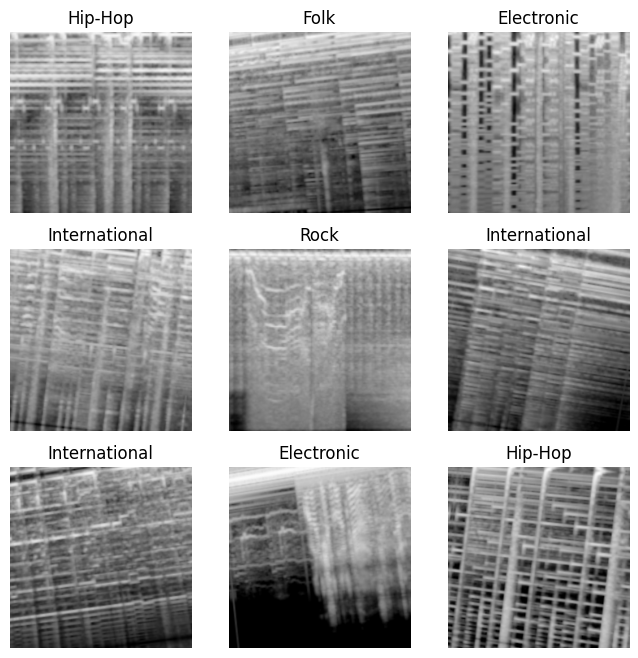

In [6]:
# DataBlock: images of spectrograms, labels = parent folder (genre)
music_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(train_name='train', valid_name='valid'),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[
        *aug_transforms(
            flip_vert=False,
            max_warp=0.05,
            max_zoom=1.1,
        ),
        Normalize.from_stats(*imagenet_stats),
    ]
)

dls = music_block.dataloaders(train_valid_root, bs=64)
dls.show_batch(max_n=9, figsize=(8, 8))


In [7]:
len(dls.train_ds), len(dls.valid_ds), dls.c, dls.vocab


(52716,
 11281,
 8,
 ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'])

In [8]:
from collections import Counter
from fastai.vision.all import *

train_files = get_image_files(DATA_SPEC/'train')
train_labels = [f.parent.name for f in train_files]
Counter(train_labels)


Counter({'Electronic': 6598,
         'Experimental': 6595,
         'Folk': 6594,
         'Hip-Hop': 6571,
         'Instrumental': 6570,
         'International': 6600,
         'Pop': 6603,
         'Rock': 6585})

### Train Model

In [9]:
learn = cnn_learner(
    dls,
    resnet50,
    metrics=accuracy,
    pretrained=True
)

learn


/usr/local/lib/python3.12/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


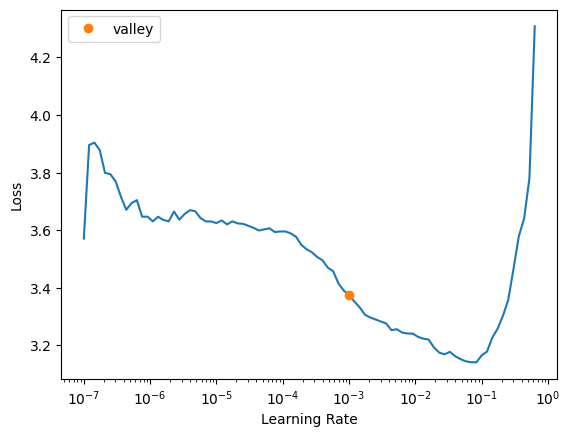

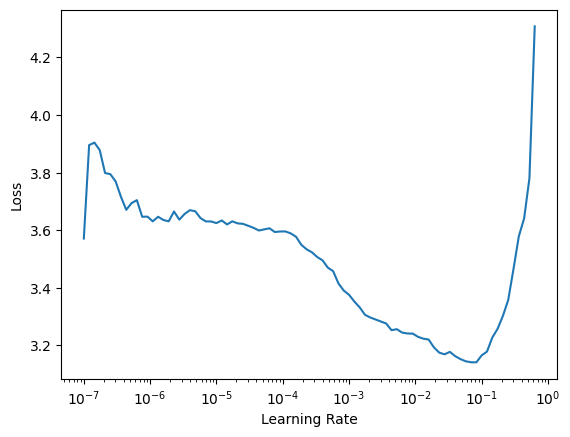

In [10]:
lr = learn.lr_find()
lr
learn.recorder.plot_lr_find()

In [12]:
lr = 1e-3  # if lr_min is None, just use 1e-3

learn.fine_tune(
    10,               # start with 10 epochs; you can increase later
    base_lr=lr
)


epoch,train_loss,valid_loss,accuracy,time
0,1.718188,1.540244,0.457584,08:08


epoch,train_loss,valid_loss,accuracy,time
0,1.492368,1.420283,0.506959,01:40
1,1.312718,1.349870,0.544721,01:39
2,1.195441,1.264839,0.566705,01:39
3,1.075169,1.233454,0.578406,01:40
4,0.995269,1.236464,0.581509,01:39
5,0.872814,1.265637,0.580268,01:40
6,0.792237,1.315923,0.580800,01:39
7,0.727345,1.341098,0.582927,01:40
8,0.698923,1.358467,0.584079,01:39
9,0.648736,1.364509,0.584700,01:39


### Evaluation

In [13]:
val_loss, val_acc = learn.validate()
val_loss, val_acc

(1.3645089864730835, 0.5846999287605286)

[('Pop', 'Rock', np.int64(237)),
 ('Experimental', 'Instrumental', np.int64(186)),
 ('Instrumental', 'Experimental', np.int64(175)),
 ('Pop', 'Folk', np.int64(161)),
 ('Electronic', 'Pop', np.int64(160)),
 ('Folk', 'Instrumental', np.int64(157)),
 ('Pop', 'Instrumental', np.int64(145)),
 ('Electronic', 'Experimental', np.int64(144)),
 ('Rock', 'Pop', np.int64(142)),
 ('Pop', 'Experimental', np.int64(140)),
 ('Pop', 'Electronic', np.int64(132)),
 ('Hip-Hop', 'Electronic', np.int64(124)),
 ('Instrumental', 'Rock', np.int64(109)),
 ('Experimental', 'Pop', np.int64(107)),
 ('Pop', 'Hip-Hop', np.int64(105)),
 ('Rock', 'Instrumental', np.int64(105)),
 ('Electronic', 'Hip-Hop', np.int64(104)),
 ('Rock', 'Folk', np.int64(102)),
 ('Instrumental', 'Folk', np.int64(101)),
 ('Folk', 'Experimental', np.int64(99)),
 ('Experimental', 'Electronic', np.int64(98)),
 ('Folk', 'Pop', np.int64(98)),
 ('International', 'Electronic', np.int64(96)),
 ('International', 'Pop', np.int64(96)),
 ('Electronic', 'In

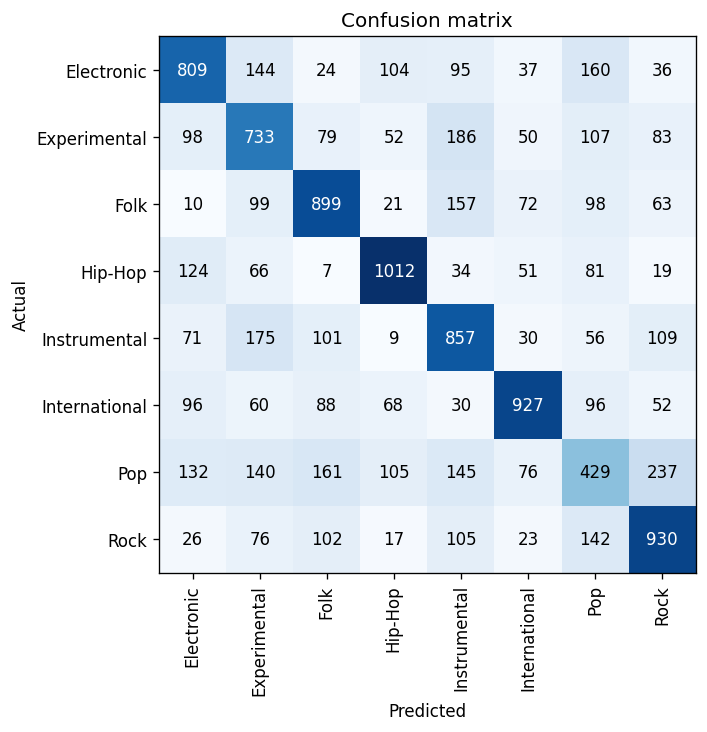

In [14]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6, 6), dpi=120)
interp.most_confused(min_val=10)

In [15]:
test_files = get_image_files(root/'test')
len(test_files), test_files[0]


(11299,
 Path('/content/drive/MyDrive/Music_Genre_Classification/data_spectrograms/test/Electronic/140261_chunk08.png'))

In [16]:
test_dl = dls.test_dl(test_files)
preds, _ = learn.get_preds(dl=test_dl)
preds.shape

torch.Size([11299, 8])

In [17]:
# True labels (as indices matching dls.vocab)
test_labels = np.array([dls.vocab.o2i[f.parent.name] for f in test_files])
test_preds = preds.argmax(dim=1).numpy()

test_acc = (test_preds == test_labels).mean()
test_acc

np.float64(0.5904947340472608)

### Save Model

In [18]:
learn.save(MODELS_DIR / 'resnet50_fma_small_stage1')

# Full export (includes architecture + preprocessing)
learn.export(MODELS_DIR / 'resnet50_fma_small_export.pkl')
MODELS_DIR

Path('/content/drive/MyDrive/Music_Genre_Classification/models')